In [5]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

FileNotFoundError: [Errno 2] No such file or directory: './/IBM_pathwise_sols_90.0.npy'

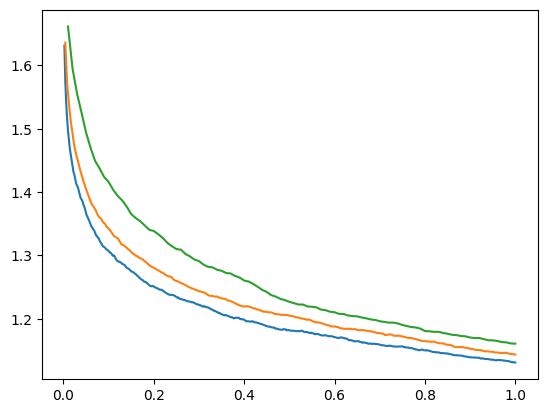

In [230]:
NS = jnp.array([500,250, 100, 90,80,70,60,50,40,30,20,10])
prefix = "IBM"
folder = "./"
for N in NS:
    paths_1 = jnp.load(f'{folder}/{prefix}_pathwise_sols_{N}.0.npy')
    paths_2 = jnp.load(f'{folder}/{prefix}_pathwise_sols2_{N}.0.npy')
    N += 1
    assert N == len(paths_1[0]) == len(paths_2[0])
    ts = jnp.linspace(0, 1, N)
    ranged = range(N)
    plt.plot(ts, -jnp.log(jnp.mean(jnp.linalg.norm(paths_1-paths_2, axis=-1),axis=0))/jnp.log(N-1),label=f'N={N-1}')
plt.legend()

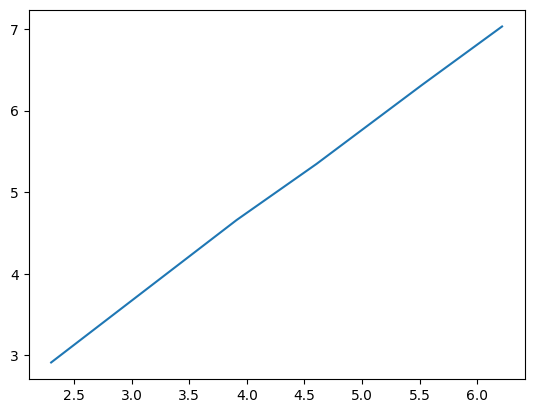

In [221]:
errs = []
for N in NS:
    paths_1 = jnp.load(f'{folder}/{prefix}_pathwise_sols_{N}.0.npy')
    paths_2 = jnp.load(f'{folder}/{prefix}_pathwise_sols2_{N}.0.npy')
    N += 1
    ts = jnp.linspace(0, 1, N)
    ranged = range(N)
    error = jnp.mean(jnp.linalg.norm(paths_1[:, -1]-paths_2[:, -1], axis=-1), axis=0)
    errs.append(error)
errs = jnp.array(errs)
plt.plot(jnp.log(NS), -jnp.log(errs))


In [222]:
linear_regressor = LinearRegression().fit(jnp.log(NS).reshape(-1, 1), -jnp.log(errs))
linear_regressor.coef_

array([1.0507251], dtype=float32)

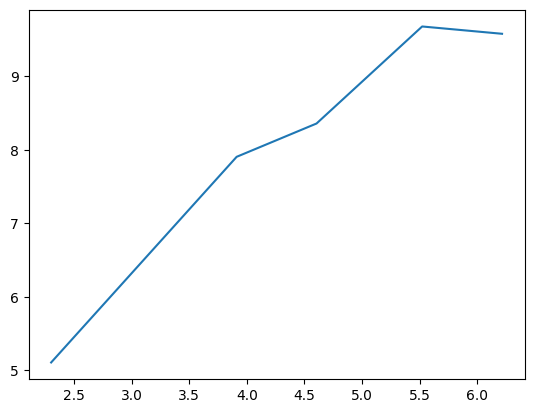

In [229]:
g = lambda x: x
errs = []
for N in NS:
    paths_1 = jnp.load(f'{folder}/{prefix}_pathwise_sols_{N}.0.npy')
    paths_2 = jnp.load(f'{folder}/{prefix}_pathwise_sols2_{N}.0.npy')
    N += 1
    assert N == len(paths_1[0]) == len(paths_2[0])
    ts = jnp.linspace(0, 1, N)
    ranged = range(N)
    
    err = jnp.max(jnp.linalg.norm(jnp.mean(g(paths_2), axis=0)-jnp.mean(g(paths_1), axis=0), axis=-1))
    errs.append(err)
errs = jnp.array(errs)
plt.plot(jnp.log(NS), -jnp.log(errs))


In [227]:
linear_regressor = LinearRegression().fit(-jnp.log(1/NS).reshape(-1, 1), -jnp.log(errs))
linear_regressor.coef_

array([1.18423], dtype=float32)

In [225]:
N = 10
paths = jnp.load(f'{folder}/{prefix}_paths_{N}.0.npy')
paths_1 = jnp.load(f'{folder}/{prefix}_pathwise_sols_{N}.0.npy')
paths_2 = jnp.load(f'{folder}/{prefix}_pathwise_sols2_{N}.0.npy')
X = jnp.cumsum(paths, axis=1)*jnp.sqrt(1/paths.shape[1])
X = jnp.insert(X, 0, 0, axis=1)
X = X[:,::int(paths.shape[1]/(paths_1.shape[1]-1))]